In [70]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
df = pd.read_csv('ca_wildfire_weather.csv')

In [72]:
print(df['Discovery_Date'].dtype)

object


In [73]:
# Convert 'Discovery_Date' to datetime 
df['Discovery_Date'] = pd.to_datetime(df['Discovery_Date'], errors='coerce')

In [74]:
# Creating a season column to use as feature to better capture variability in fire occurences throughout year, allowing model to learn patterns related to each season.

# Extract month from Discovery_Date
df['Month'] = df['Discovery_Date'].dt.month

# map month to season
def get_season(month):
    if month in [12, 1, 2]:  # dec, jan, feb
        return 'Winter'
    elif month in [3, 4, 5]:  # mar, apr, may
        return 'Spring'
    elif month in [6, 7, 8]:  # jun, jul, aug
        return 'Summer'
    else:
        return 'Fall'  # sep, oct, nov

# Apply function to create 'Season' col
df['Season'] = df['Month'].apply(get_season)

# Drop month col as no longer needed
df.drop('Month', axis=1, inplace=True)

df[['Discovery_Date', 'Season']].head()

,Discovery_Date,Season
0,2004-10-06,Fall
1,2004-10-13,Fall
2,2005-07-09,Summer
3,2005-08-24,Summer
4,2005-09-16,Fall


In [75]:
# Creating new column to see if human fires fall on any holidays (need to do more eda on this, but want to see how this affects model)

from datetime import timedelta

# Function to generate holiday dates for a given year
def generate_holidays(year):
    holidays = [
        pd.Timestamp(year=year, month=1, day=1),  # New Year's Day
        pd.Timestamp(year=year, month=7, day=4),  # Independence Day
        pd.Timestamp(year=year, month=12, day=25),  # Christmas
        # Thanksgiving (Fourth Thursday of November)
        pd.Timestamp(year=year, month=11, day=1) + pd.offsets.Week(3) + timedelta(days=(3 - pd.Timestamp(year=year, month=11, day=1).day % 7) % 7)
    ]
    return holidays

# Create a list of holiday dates for all years in dataset
start_year = df['Discovery_Date'].dt.year.min()
end_year = df['Discovery_Date'].dt.year.max()
all_holidays = []

for year in range(start_year, end_year + 1):
    all_holidays.extend(generate_holidays(year))

# Convert to a set for faster lookup
holiday_dates_set = set(pd.to_datetime(all_holidays))

# Create a binary variable for holidays
df['Is_Holiday'] = df['Discovery_Date'].dt.date.isin(holiday_dates_set).astype(int)

/var/folders/h_/q1_b1v7x1p3dp6dhckks0t180000gn/T/ipykernel_93349/828906749.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_counts.index, y=holiday_counts.values, palette='pastel')


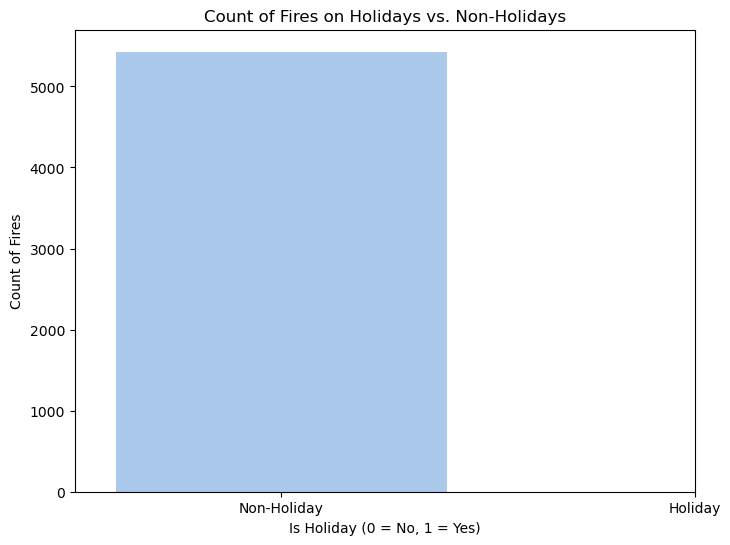

In [76]:
# Pause for some eda using these new columns to see if useful

# Count the occurrences of fires based on holidays
holiday_counts = df['Is_Holiday'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=holiday_counts.index, y=holiday_counts.values, palette='pastel')
plt.title('Count of Fires on Holidays vs. Non-Holidays')
plt.xlabel('Is Holiday (0 = No, 1 = Yes)')
plt.ylabel('Count of Fires')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

Alright, that was useless... kind of surprised tho especially for fourth of july.. but original eda didnt show many fires caused by fireworks from this csv so makes sense

/var/folders/h_/q1_b1v7x1p3dp6dhckks0t180000gn/T/ipykernel_93349/4049546162.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_counts.index, y=season_counts.values, palette='coolwarm')


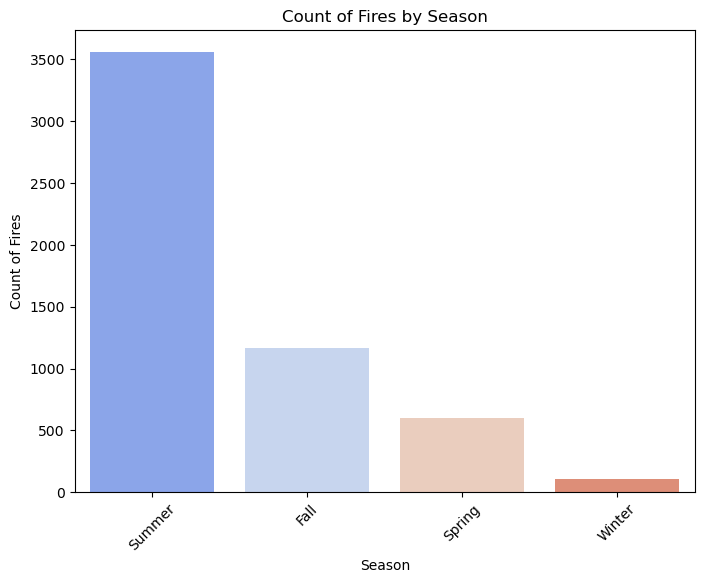

/var/folders/h_/q1_b1v7x1p3dp6dhckks0t180000gn/T/ipykernel_93349/4049546162.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Season', y='Fire_Size_Acres', data=df, palette='coolwarm')


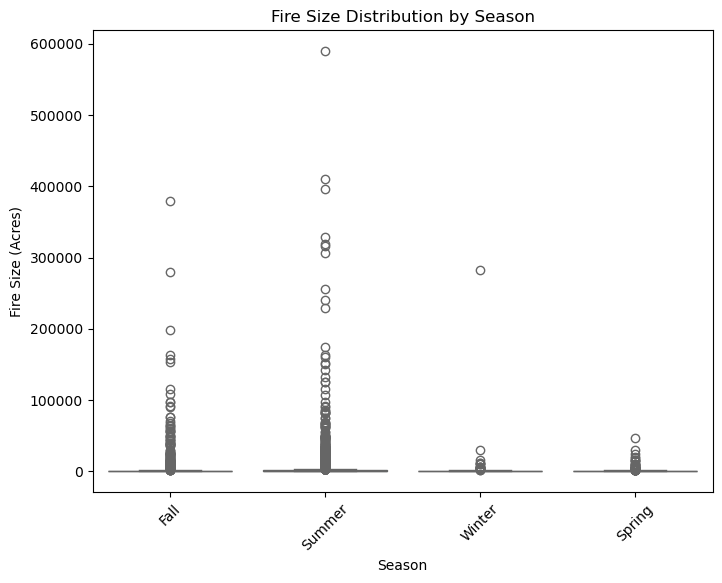

In [77]:
# Now looking at seasons

plt.figure(figsize=(8, 6))
season_counts = df['Season'].value_counts()
sns.barplot(x=season_counts.index, y=season_counts.values, palette='coolwarm')
plt.title('Count of Fires by Season')
plt.xlabel('Season')
plt.ylabel('Count of Fires')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x='Season', y='Fire_Size_Acres', data=df, palette='coolwarm')
plt.title('Fire Size Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Fire Size (Acres)')
plt.xticks(rotation=45)
plt.show()

This makes sense and may be useful for prediction model



Since the undetermined category is relatively small (500) compared to the human and natural causes, dropping the undetermined causes and using a binary classification model would be a good approach for a cleaner and simpler model... going to proceed with that below.

By keeping the undetermined data as a third class, we'd be working with a multi-class classification problem (Human, Natural, and Undetermined).
This option could make our model more flexible in dealing with incomplete information. May want to analyze whether the conditions in undetermined cases resemble human or natural causes and see if our model could predict them accurately.
If we want to build a comprehensive model that accounts for the uncertainties we could try this. I'll attempt this one later.

In [78]:
# Drop Undetermined classification to reduce noise for a cleaner and simpler model
df = df[df['Cause_Classification'].isin(['Human', 'Natural'])]

In [79]:
# Verify only human/natural causes remain
df['Cause_Classification'].value_counts()

Cause_Classification
Human      3801
Natural    1098
Name: count, dtype: int64

In [80]:
df.columns

Index(['Unnamed: 0', 'Object_ID', 'Fire_Occurrence_Database_ID',
       'Fire_Program_Analysis_ID', 'Reporting_Agency', 'Reporting_Unit_Name',
       'Fire_Year', 'Discovery_Date', 'Discovery_Day_of_Year',
       'Discovery_Time', 'Cause_Classification', 'General_Cause',
       'Fire_Size_Acres', 'Fire_Size_Class', 'Latitude', 'Longitude', 'State',
       'FIPS_Name', 'Week_Before_Discovery_Date', 'Avg_Max_Temp',
       'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine', 'Avg_Wind_Speed',
       'Avg_Wind_Gusts', 'Primary_Wind_Direction', 'Season', 'Is_Holiday'],
      dtype='object')

In [81]:
# Drop unnecessary columns that we dont need for prediction model
drop_columns = ['Unnamed: 0', 'Object_ID', 'Fire_Occurrence_Database_ID',
                'Fire_Program_Analysis_ID', 'Reporting_Agency', 'Reporting_Unit_Name', 'Discovery_Day_of_Year',
                'State', 'FIPS_Name', 'General_Cause', 'Week_Before_Discovery_Date', 'Discovery_Date', 'Is_Holiday']
df = df.drop(columns=drop_columns)

In [82]:
df.columns

Index(['Fire_Year', 'Discovery_Time', 'Cause_Classification',
       'Fire_Size_Acres', 'Fire_Size_Class', 'Latitude', 'Longitude',
       'Avg_Max_Temp', 'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine',
       'Avg_Wind_Speed', 'Avg_Wind_Gusts', 'Primary_Wind_Direction', 'Season'],
      dtype='object')

In [83]:
# Convert Discovery Time to categories

# Check the first few rows of the Discovery_Time column
print(df['Discovery_Time'].head())
# Display unique values in the Discovery_Time column
print(df['Discovery_Time'].unique())
# Check for missing values
print(df['Discovery_Time'].isnull().sum())
# Check the data type of Discovery_Time
print(df['Discovery_Time'].dtype)
# Summary statistics (if the column is numeric)
print(df['Discovery_Time'].describe())

0    1415.0
1    1618.0
2    1313.0
3    1110.0
4    1435.0
Name: Discovery_Time, dtype: float64
[1.415e+03 1.618e+03 1.313e+03 1.110e+03 1.435e+03 1.455e+03 1.730e+03
 1.335e+03 1.338e+03 1.458e+03 2.012e+03 1.745e+03 1.451e+03 1.737e+03
 1.929e+03 1.330e+03 1.380e+02 1.245e+03 1.437e+03 1.615e+03 1.334e+03
 2.030e+03 1.316e+03 1.636e+03 1.530e+03 1.709e+03 1.118e+03 1.520e+03
 1.249e+03 1.232e+03 1.200e+03 1.717e+03 1.705e+03 1.037e+03 2.055e+03
 1.725e+03 4.100e+02 1.620e+03 1.319e+03 6.050e+02 1.825e+03 1.609e+03
 1.631e+03 1.414e+03 1.703e+03 1.630e+03 9.300e+02 1.143e+03 1.551e+03
 1.710e+03 1.354e+03 2.222e+03 7.300e+02 1.800e+03 1.508e+03 1.413e+03
 1.624e+03 1.322e+03 8.270e+02 6.020e+02 1.203e+03 2.330e+03 8.560e+02
 9.500e+02 1.420e+03 1.436e+03 1.556e+03 2.005e+03 1.159e+03 1.635e+03
 1.440e+03 1.220e+02 1.821e+03 8.000e+02 1.300e+03 8.330e+02 1.149e+03
 1.040e+03 1.500e+03 1.605e+03 1.830e+03 1.109e+03 1.446e+03 1.407e+03
 1.317e+03 1.419e+03 1.237e+03 1.131e+03 1.230e+03 

In [84]:
# Fill NaN values with 'Unknown'
df['Discovery_Time'].fillna('Unknown', inplace=True)

/var/folders/h_/q1_b1v7x1p3dp6dhckks0t180000gn/T/ipykernel_93349/2922414041.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Discovery_Time'].fillna('Unknown', inplace=True)
/var/folders/h_/q1_b1v7x1p3dp6dhckks0t180000gn/T/ipykernel_93349/2922414041.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df['Discovery_Time'].fillna('Unknown', i

In [85]:
# Categorize the column into morning/afternoon/evening/night or unknown


def categorize_time(row):
    if pd.isna(row):  # Check for NaN values
        return 'Unknown'
    
    try:
        # Convert the row to string and pad with zeros if necessary
        military_time = str(int(row)).zfill(4)
        
        # Extract hours and minutes
        hour = int(military_time[:2])  # First two characters as hour
        minute = int(military_time[2:])  # Last two characters as minute

        # Categorize based on hour
        if 6 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 18:
            return "Afternoon"
        elif 18 <= hour < 24:
            return "Evening"
        else:
            return "Night"  # This handles the range for Night (0 to 5)
    except ValueError:
        return 'Unknown'  # Handle any unexpected input

# Apply the function to create a 'Time_of_Day' category
df['Time_of_Day'] = df['Discovery_Time'].apply(categorize_time)

# Check the result
print(df[['Discovery_Time', 'Time_of_Day']])

     Discovery_Time Time_of_Day
0            1415.0   Afternoon
1            1618.0   Afternoon
2            1313.0   Afternoon
3            1110.0     Morning
4            1435.0   Afternoon
...             ...         ...
5409        Unknown     Unknown
5410        Unknown     Unknown
5411        Unknown     Unknown
5412        Unknown     Unknown
5413        Unknown     Unknown

[4899 rows x 2 columns]


In [86]:
# Drop the Discovery_Time column
df.drop(columns=['Discovery_Time'], inplace=True)

# consider dropping either fire size class or fire size acres to reduce redundancy?

In [87]:
df.columns

Index(['Fire_Year', 'Cause_Classification', 'Fire_Size_Acres',
       'Fire_Size_Class', 'Latitude', 'Longitude', 'Avg_Max_Temp',
       'Avg_Min_Temp', 'Avg_Precipitation', 'Avg_Sunshine', 'Avg_Wind_Speed',
       'Avg_Wind_Gusts', 'Primary_Wind_Direction', 'Season', 'Time_of_Day'],
      dtype='object')

In [88]:
# One-Hot Encoding
df = pd.get_dummies(df, columns=['Season', 'Time_of_Day', 'Fire_Size_Class'], drop_first=True)

In [90]:
# Define target and features
X = df.drop(columns=['Cause_Classification'])  # Features
y = df['Cause_Classification']  # Target variable

In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
# Check types to ensure model success
print(X_train.dtypes)
print(X.head())
print(y.head())

Fire_Year                   int64
Fire_Size_Acres           float64
Latitude                  float64
Longitude                 float64
Avg_Max_Temp              float64
Avg_Min_Temp              float64
Avg_Precipitation         float64
Avg_Sunshine              float64
Avg_Wind_Speed            float64
Avg_Wind_Gusts            float64
Primary_Wind_Direction    float64
Season_Spring                bool
Season_Summer                bool
Season_Winter                bool
Time_of_Day_Evening          bool
Time_of_Day_Morning          bool
Time_of_Day_Night            bool
Time_of_Day_Unknown          bool
Fire_Size_Class_E            bool
Fire_Size_Class_F            bool
Fire_Size_Class_G            bool
dtype: object
   Fire_Year  Fire_Size_Acres   Latitude   Longitude  Avg_Max_Temp  \
0       2004          16823.0  38.523333 -120.211667       68.0750   
1       2004           7700.0  38.780000 -120.260000       70.5375   
2       2005           1149.0  35.688056 -118.438333       93.

In [93]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [104]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

In [105]:
# Evaluate Performance

# Print classification report
print(classification_report(y_test, y_pred))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

       Human       0.92      0.96      0.94       766
     Natural       0.84      0.69      0.76       214

    accuracy                           0.90       980
   macro avg       0.88      0.83      0.85       980
weighted avg       0.90      0.90      0.90       980

Confusion Matrix:
 [[739  27]
 [ 67 147]]


### Classification Report Summary

Precision:
- Human: 0.92 – when the model predicts a fire is human-caused, it is correct 92% of the time.
- Natural: 0.84 – The model correctly predicts natural fires 84% of the time.

Recall:
- Human: 0.96 – The model identifies 96% of actual human-caused fires.
- Natural: 0.69 – The model identifies only 69% of actual natural-caused fires, indicating it may be missing a significant number of natural fires.

F1-Score:
- Human: 0.94 – This score balances precision and recall, indicating excellent performance.
- Natural: 0.76 – This is lower, suggesting the model struggles more with predicting natural fires.
  
Accuracy: 0.90 – Overall, the model correctly predicts the fire cause 90% of the time.

### Confusion Matrix:
[739 , 27] - Predicted Human, Actual Human / Predicted Human, Actual Natural

[ 67 , 147] - Predicted Natural, Actual Human / Predicted Natural, Actual Natural

## Key Insights
- Strong Human Prediction: The model performs very well in predicting human-caused fires, with high precision and recall.
  
- Lower Natural Recall: The lower recall for natural fires suggests that the model may not be capturing all instances of natural fires. This could be due to class imbalance (more human-caused examples) or something else

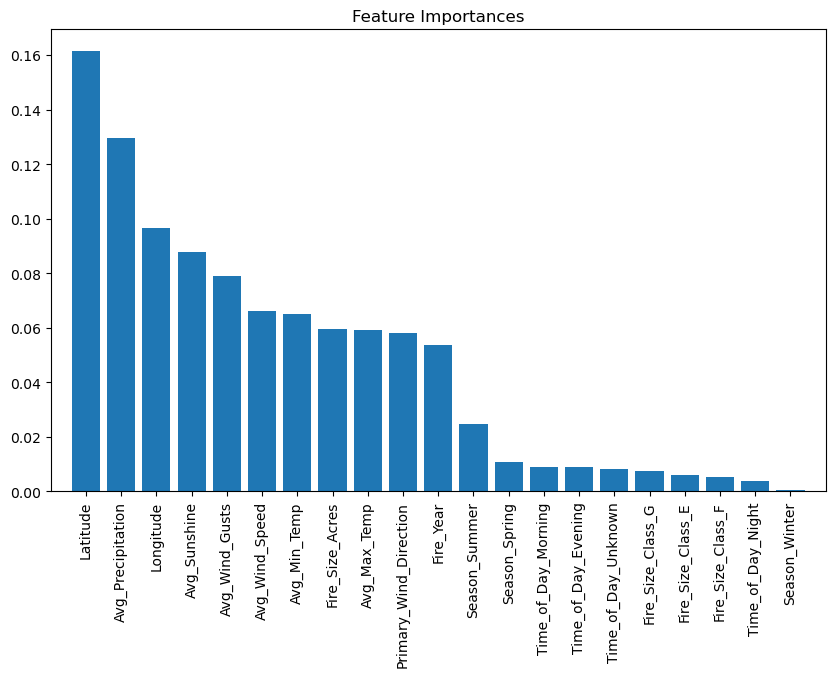

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf_model.feature_importances_

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Hyperparameter tuning using GridSearchCV to help improve performance by finding the best combination of hyperparameters.

In [97]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


### Update Model with best parameters

In [98]:
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

In [99]:
# Re-train model 
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=42)

In [106]:
# Make predictions on the validation set
y_pred = best_rf_model.predict(X_test)

In [108]:
# Generate the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

       Human       0.92      0.96      0.94       766
     Natural       0.82      0.68      0.75       214

    accuracy                           0.90       980
   macro avg       0.87      0.82      0.84       980
weighted avg       0.90      0.90      0.90       980

Confusion Matrix:
 [[735  31]
 [ 68 146]]


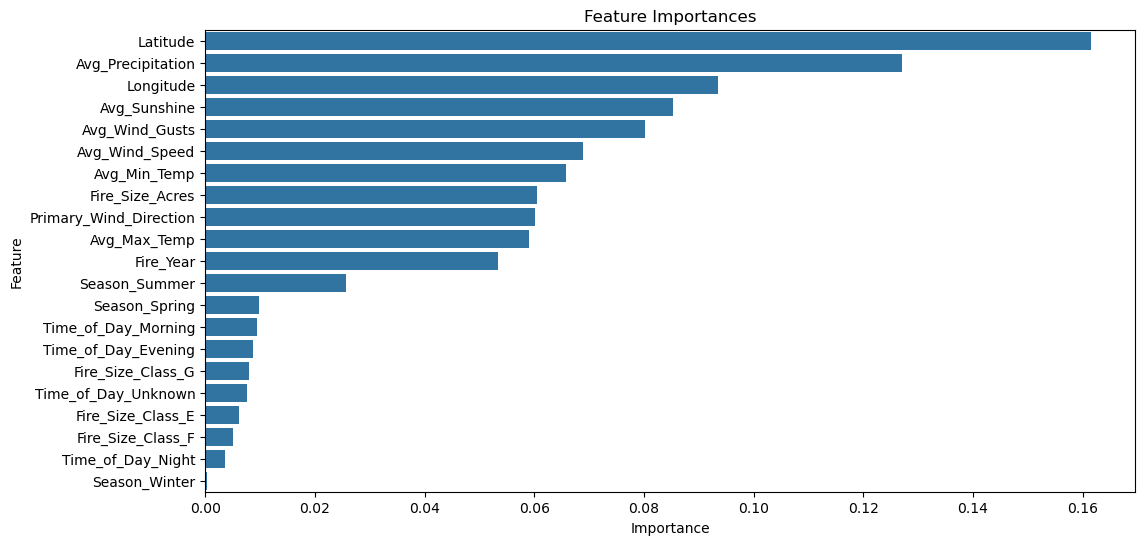

In [110]:
# Get feature importances
importances = best_rf_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()


### Addressing class imbalance to try and improve performance 

Using SMOTE can help model better learn the characteristics of the minority (natural) class by balancing the class distributions using synthetic samples based on existing instances, potentially improving its ability to predict the class of interest

In [113]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [114]:
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of the classes after resampling
print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_resampled))

Original dataset shape: Counter({'Human': 3035, 'Natural': 884})
Resampled dataset shape: Counter({'Human': 3035, 'Natural': 3035})


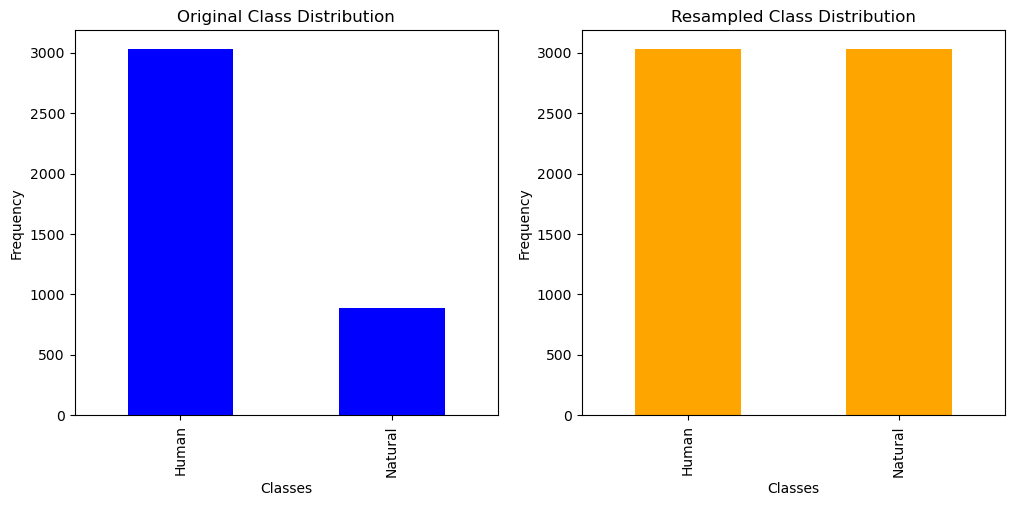

In [118]:
import matplotlib.pyplot as plt

# Plotting original vs resampled class distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Original data
y_train.value_counts().plot(kind='bar', ax=ax[0], color='blue', title='Original Class Distribution')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Classes')

# Resampled data
y_resampled.value_counts().plot(kind='bar', ax=ax[1], color='orange', title='Resampled Class Distribution')
ax[1].set_ylabel('Frequency')
ax[1].set_xlabel('Classes')

plt.show()

In [116]:
# Initialize the Random Forest Classifier again
best_rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the resampled data
best_rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [117]:
# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       Human       0.94      0.93      0.93       766
     Natural       0.75      0.79      0.77       214

    accuracy                           0.90       980
   macro avg       0.84      0.86      0.85       980
weighted avg       0.90      0.90      0.90       980

Confusion Matrix:
 [[709  57]
 [ 45 169]]


Still getting 90% accuracy, but natural predictions have improved